<a href="https://colab.research.google.com/github/princexoleo/machine-learning/blob/master/pneumonia_chest_x_ray_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pneumonia Detection from Chest X-Ray images with Fastai

Chest X-ray dataset from kaggle.For Kaggle api uses we need to install kaggle api
```
!pip install kaggel
```

In [0]:
#install  kaggle dependencies
!pip install kaggle

For kaggle authentication, upload kaggle api json file which can downloaded from kaggle account

In [0]:
from google.colab import files
files.upload()

create a directory and store the kaggle json file

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission
!chmod 600 ~/.kaggle/kaggle.json

Chest xray datasets download link copy from kaggle websites

In [9]:
# Kaggle datasets url link paste here ..
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:35<00:00, 70.1MB/s]
100% 2.29G/2.29G [00:35<00:00, 69.9MB/s]


Extract zip files

In [10]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Using Fastai
Using Fastai Deep Learning Libraries

Import Necessary Libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os

datasets  directory

In [0]:
data_dir = "/content/chest_xray/chest_xray"
train_dir = data_dir+'/train'
test_dir = data_dir+'/test'
valid_dir = data_dir+'/val'

In [14]:
path = Path(data_dir)
path.ls()

[PosixPath('/content/chest_xray/chest_xray/test'),
 PosixPath('/content/chest_xray/chest_xray/train'),
 PosixPath('/content/chest_xray/chest_xray/.DS_Store'),
 PosixPath('/content/chest_xray/chest_xray/val')]

Show an images from datasets directory

torch.Size([3, 1225, 1632])


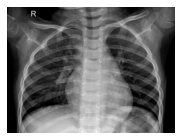

In [15]:
img = open_image(path/'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
print(img.data.shape)
img.show()

In [0]:
tfms = get_transforms()
bs = 64

In [0]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path,
                                  valid ='val',
                                  valid_pct=0.2,
                                  size=299,
                                  bs = bs,
                                  ds_tfms=tfms).normalize(imagenet_stats)

show batches data


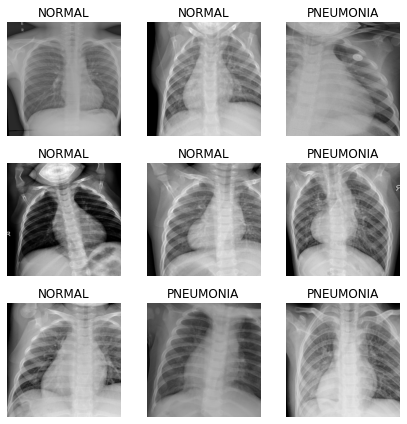

In [18]:
data.show_batch(3, figsize=(6,6))

In [19]:
print(data.classes)
print(data.c)
print(len(data.train_ds))
print(len(data.valid_ds))


['NORMAL', 'PNEUMONIA']
2
4685
1171


Model: resnet50

In [20]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Learner(data=ImageDataBunch;

Train: LabelList (4685 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray/chest_xray;

Valid: LabelList (1171 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /content/chest_xray/chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.458732,0.322357,0.098207,05:05
1,0.265756,0.160249,0.050384,05:00
2,0.189941,0.141909,0.044406,04:57
3,0.147548,0.110760,0.040137,04:57


In [0]:
# save the model with weights
save_dir = "/content/chest_xray/modelsave/"
learn.save('stage-1')

 For testing perpouse

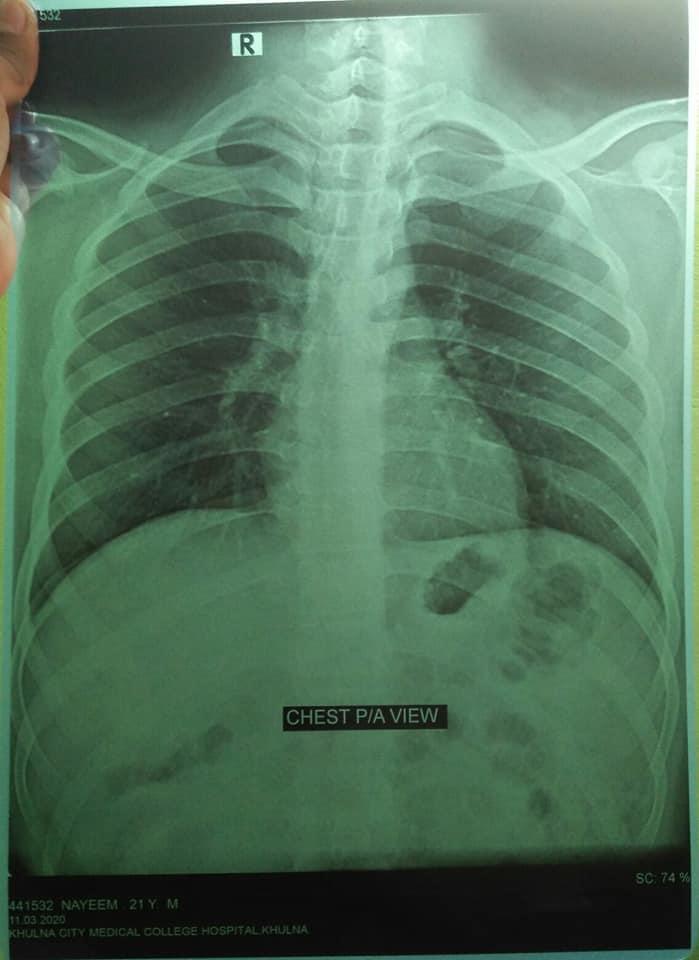

In [23]:
img = open_image('/content/test_tensor.jpeg')
img

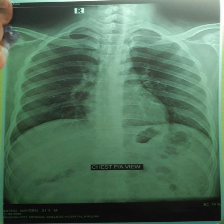

In [24]:
img.resize(224)

In [26]:
print(img.data.shape)
learn.predict(img)

torch.Size([3, 224, 224])


(Category PNEUMONIA, tensor(1), tensor([5.5555e-05, 9.9994e-01]))

In [27]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


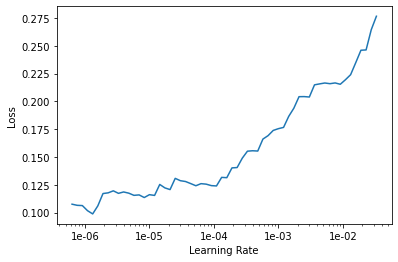

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.117665,0.134585,0.044406,05:10
1,0.127245,0.104711,0.028181,05:04
2,0.109088,0.118867,0.039283,05:04
3,0.094889,0.077206,0.026473,05:04
4,0.080504,0.091396,0.025619,05:02
5,0.066847,0.053016,0.013664,05:03
6,0.056098,0.084897,0.022203,05:05
7,0.040574,0.081281,0.020495,04:55
8,0.035599,0.071109,0.021349,05:07
9,0.029527,0.064916,0.021349,04:59


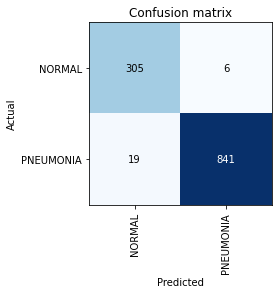

In [30]:
learn.save('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

##Testing with real life x-ray datasets

impor images for testing purpose

In [48]:
## this is normal healty people chest x-ray collected from internet
normal_test = open_image('/content/normal_test_1.jpg').resize(224)
p_test = open_image('/content/test_tensor.jpeg').resize(224)
print(normal_test, p_test)

Image (3, 438, 500) Image (3, 960, 699)


In [0]:
def result_show(pred):
  print("Finally Predicted Result is : ",pred[0])
  print("Matched with Normal is :", pred[2][0])
  print("Matched with Pneumonia is :", pred[2][1])


In [0]:
def prediction_images(i):
  print(i.show())
  pred = learn.predict(i)
  #print(pred)
  result_show(pred)

None
Finally Predicted Result is :  NORMAL
Matched with Normal is : tensor(0.9551)
Matched with Pneumonia is : tensor(0.0449)
None
Finally Predicted Result is :  PNEUMONIA
Matched with Normal is : tensor(0.0364)
Matched with Pneumonia is : tensor(0.9636)


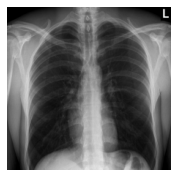

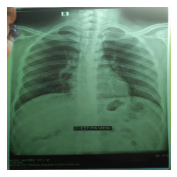

In [56]:
prediction_images(normal_test)
prediction_images(p_test)

In [0]:
learn.export()

In [61]:
learn.path.ls()

[PosixPath('/content/chest_xray/chest_xray/test'),
 PosixPath('/content/chest_xray/chest_xray/train'),
 PosixPath('/content/chest_xray/chest_xray/.DS_Store'),
 PosixPath('/content/chest_xray/chest_xray/models'),
 PosixPath('/content/chest_xray/chest_xray/export.pkl'),
 PosixPath('/content/chest_xray/chest_xray/val')]